In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os
from itertools import islice
import re
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F  
import math
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

C:\Users\SILA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
comments_path = os.path.join(os.path.expanduser("~"), "Desktop\\TrendyolMilla\\03_Data_Labelization\\Data\\Bert", "comments_bert_consolidation.csv")

df_comments = pd.read_csv(comments_path)

df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi ol...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Boyum 1.65 bir tık daha uzun olsa elbise iyi o...,135,boyum 1.65 bir tık daha uzun olsa elbise iyi o...,Negative,-0.669085,Positive,0.991367,Positive,0.161141
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil...,Negative,-0.964131,Positive,0.924904,Negative,-0.019614
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 ...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Xs uzun süredir gelmediği için s aldım 157*46 ...,140,xs uzun süredir gelmediği için s aldım 157*46 ...,Negative,-0.999406,Positive,0.791039,Negative,-0.104184


1 - Zero Shot : joeddav/xlm-roberta-large-xnli 

In [ ]:
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

labels = ["olumlu", "olumsuz"]

BATCH_SIZE = 32
MAX_LENGTH = 512

yorumlar = df_comments["Yorum_V1"].fillna("").tolist()  

tahminler = []

for i in tqdm(range(0, len(yorumlar), BATCH_SIZE), desc="Zero-shot Sentiment Analizi"):
    batch = yorumlar[i:i+BATCH_SIZE]

    results = classifier(batch, candidate_labels=labels, truncation=True, max_length=MAX_LENGTH)

    for sonuc in results:

        en_yuksek_idx = sonuc["scores"].index(max(sonuc["scores"]))
        tahminler.append({
            "joeddav_label": sonuc["labels"][en_yuksek_idx],
            "joeddav_skor": sonuc["scores"][en_yuksek_idx]
        })

df_tahmin = pd.DataFrame(tahminler)
df_comments = pd.concat([df_comments.reset_index(drop=True), df_tahmin], axis=1)

df_comments.head()

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Zero-shot Sentiment Analizi: 100%|██████████| 3411/3411 [8:01:27<00:00,  8.47s/it]  


,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi ol...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Boyum 1.65 bir tık daha uzun olsa elbise iyi o...,135,boyum 1.65 bir tık daha uzun olsa elbise iyi o...,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil...,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 ...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Xs uzun süredir gelmediği için s aldım 157*46 ...,140,xs uzun süredir gelmediği için s aldım 157*46 ...,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,0.631333


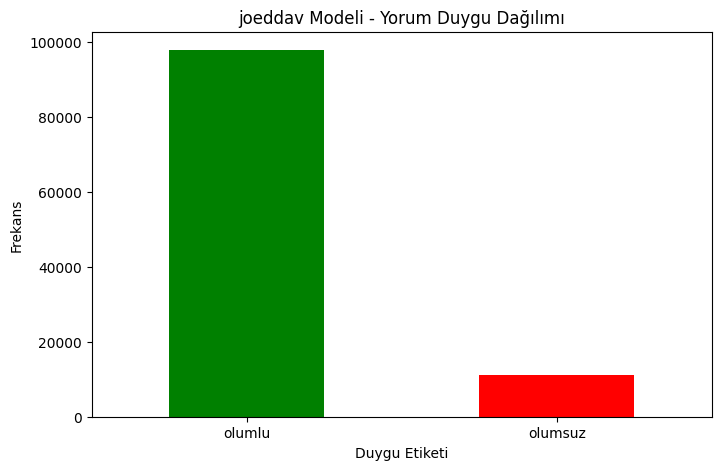

In [ ]:
label_counts = df_comments["joeddav_label"].value_counts()

plt.figure(figsize=(8, 5))
label_counts.plot(kind="bar", color=["green", "red"])  
plt.xlabel("Duygu Etiketi")
plt.ylabel("Frekans")
plt.title("Joeddav Modeli - Yorum Duygu Dağılımı")
plt.xticks(rotation=0)  
plt.show()

In [4]:
df_comments["joeddav_label"].value_counts()

joeddav_label
olumlu     97916
olumsuz    11226
Name: count, dtype: int64

In [5]:
df_comments["joeddav_skor"] = df_comments.apply( lambda row: row["joeddav_skor"] * -1 if row["joeddav_label"] == "olumsuz" else row["joeddav_skor"],   axis=1)
df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi ol...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Boyum 1.65 bir tık daha uzun olsa elbise iyi o...,135,boyum 1.65 bir tık daha uzun olsa elbise iyi o...,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil...,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 ...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Xs uzun süredir gelmediği için s aldım 157*46 ...,140,xs uzun süredir gelmediği için s aldım 157*46 ...,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333


In [7]:
print((df_comments["joeddav_skor"] > 0).sum(), "pozitif değer")
print((df_comments["joeddav_skor"] < 0).sum(), "negatif değer")
print((df_comments["joeddav_skor"] == 0).sum(), "sıfır")

97916 pozitif değer
11226 negatif değer
0 sıfır


In [8]:
max_lengt = max(df_comments["joeddav_skor"] )
min_lengt = min(df_comments["joeddav_skor"] )

print("Max Skor: ", max_lengt)
print("Min Skor: ", min_lengt)

Max Skor:  0.9995312690734864
Min Skor:  -0.9995995759963988


In [ ]:
comment_path = os.path.join(os.path.expanduser("~"), "Desktop\\TrendyolMilla\\03_Data_Labelization\\Data\\Zero_Shot")
file_name = "comments_joeddav.csv"
file_path = os.path.join(comment_path, file_name)
df_comments.to_csv(file_path, index=False)  
print(f"{file_name} olarak kaydedildi.") 

comments_joeddav.csv olarak kaydedildi.


In [ ]:
comments_path = os.path.join(os.path.expanduser("~"), "Desktop\\TrendyolMilla\\03_Data_Labelization\\Data\\Zero_Shot", "comments_joeddav.csv")

df_comments = pd.read_csv(comments_path)

df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi ol...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Boyum 1.65 bir tık daha uzun olsa elbise iyi o...,135,boyum 1.65 bir tık daha uzun olsa elbise iyi o...,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil...,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 ...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Xs uzun süredir gelmediği için s aldım 157*46 ...,140,xs uzun süredir gelmediği için s aldım 157*46 ...,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333


2 - kaixkhazaki/turkish-zeroshot-distilbert

In [ ]:
classifier = pipeline(
    "zero-shot-classification",
    model="kaixkhazaki/turkish-zeroshot-distilbert",
    device=0 if torch.cuda.is_available() else -1
)

candidate_labels = ["olumlu", "olumsuz"]

labels = []
scores = []

for yorum in tqdm(df_comments["Yorum_V1"], desc="Zero-shot Analiz"):
    result = classifier(yorum, candidate_labels)
    labels.append(result["labels"][0])
    scores.append(result["scores"][0])

df_comments["kaixkhazaki_label"] = labels
df_comments["kaixkhazaki_skor"] = scores

C:\Users\SILA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SILA\.cache\huggingface\hub\models--kaixkhazaki--turkish-zeroshot-distilbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Device set to use cpu
Zero-shot Analiz: 100%|██████████| 109142/109142 [1:18:07<00:00, 23.28it/s]


In [11]:
df_comments["kaixkhazaki_label"].value_counts()

kaixkhazaki_label
olumlu     98644
olumsuz    10498
Name: count, dtype: int64

In [13]:
df_comments["kaixkhazaki_skor"] = df_comments.apply( lambda row: row["kaixkhazaki_skor"] * -1 if row["kaixkhazaki_label"] == "olumsuz" else row["kaixkhazaki_skor"],   axis=1)
df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684,olumlu,0.930659
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi ol...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Boyum 1.65 bir tık daha uzun olsa elbise iyi o...,135,boyum 1.65 bir tık daha uzun olsa elbise iyi o...,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270,olumlu,0.857906
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil...,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739,olumlu,0.886708
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717,olumlu,0.956035
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 ...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Xs uzun süredir gelmediği için s aldım 157*46 ...,140,xs uzun süredir gelmediği için s aldım 157*46 ...,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333,olumlu,0.595040


In [14]:
max_lengt = max(df_comments["kaixkhazaki_skor"] )
min_lengt = min(df_comments["kaixkhazaki_skor"] )

print("Max Skor: ", max_lengt)
print("Min Skor: ", min_lengt)

Max Skor:  0.9919149875640869
Min Skor:  -0.9876564145088196


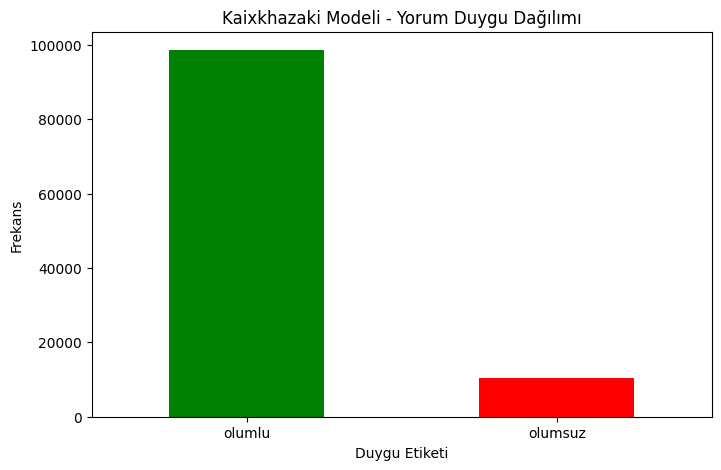

In [ ]:
label_counts = df_comments["kaixkhazaki_label"].value_counts()

plt.figure(figsize=(8, 5))
label_counts.plot(kind="bar", color=["green", "red"])  
plt.xlabel("Duygu Etiketi")
plt.ylabel("Frekans")
plt.title("Kaixkhazaki Modeli - Yorum Duygu Dağılımı")
plt.xticks(rotation=0)  
plt.show()

In [ ]:
comment_path = os.path.join(os.path.expanduser("~"), "Desktop\\TrendyolMilla\\03_Data_Labelization\\Data\\Zero_Shot")
file_name = "comments_kaixkhazaki.csv"
file_path = os.path.join(comment_path, file_name)
df_comments.to_csv(file_path, index=False) 
print(f"{file_name} olarak kaydedildi.") 

comments_kaixkhazaki.csv olarak kaydedildi.


3 - MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7

In [ ]:
comments_path = os.path.join(os.path.expanduser("~"), "Desktop\\TrendyolMilla\\03_Data_Labelization\\Data\\Zero_Shot", "comments_kaixkhazaki.csv")

df_comments = pd.read_csv(comments_path)

df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684,olumlu,0.930659
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi ol...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Boyum 1.65 bir tık daha uzun olsa elbise iyi o...,135,boyum 1.65 bir tık daha uzun olsa elbise iyi o...,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270,olumlu,0.857906
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,1.68 boy 60 kilo s beden cuk oturdu. Wow değil...,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil...,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739,olumlu,0.886708
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717,olumlu,0.956035
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 ...,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda O...,Xs uzun süredir gelmediği için s aldım 157*46 ...,140,xs uzun süredir gelmediği için s aldım 157*46 ...,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333,olumlu,0.595040


In [ ]:
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None) 

In [ ]:
model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

zero_shot_pipeline = pipeline("zero-shot-classification", model=model, tokenizer=tokenizer)

yorumlar = df_comments["Yorum_V1"].tolist()

labels = ["olumlu", "olumsuz"]

sonuclar = []
for yorum in tqdm(yorumlar, desc="Zero-Shot Analiz Ediliyor", unit="yorum"):
    result = zero_shot_pipeline(yorum, candidate_labels=labels)
    
    sonuclar.append({
        "MoritzLaurer_label": result["labels"][0],  
        "MoritzLaurer_skor": result["scores"][0]   
    })

df_comments["MoritzLaurer_label"] = [sonuc["MoritzLaurer_label"] for sonuc in sonuclar]
df_comments["MoritzLaurer_skor"] = [sonuc["MoritzLaurer_skor"] for sonuc in sonuclar]

C:\Users\SILA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SILA\.cache\huggingface\hub\models--MoritzLaurer--mDeBERTa-v3-base-xnli-multilingual-nli-2mil7. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(m

In [ ]:
df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor,MoritzLaurer_label,MoritzLaurer_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684,olumlu,0.930659,olumlu,0.984298
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,135,boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270,olumlu,0.857906,olumsuz,0.775901
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. yaka kesimi hoş. biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739,olumlu,0.886708,olumlu,0.897199
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717,olumlu,0.956035,olumlu,0.985931
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,140,xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333,olumlu,0.595040,olumsuz,0.520216


In [10]:
df_comments["MoritzLaurer_label"].value_counts()

MoritzLaurer_label
olumlu     88694
olumsuz    20448
Name: count, dtype: int64

In [11]:
df_comments["MoritzLaurer_skor"] = df_comments.apply( lambda row: row["MoritzLaurer_skor"] * -1 if row["MoritzLaurer_label"] == "olumsuz" else row["MoritzLaurer_skor"],   axis=1)
df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor,MoritzLaurer_label,MoritzLaurer_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684,olumlu,0.930659,olumlu,0.984298
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,135,boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270,olumlu,0.857906,olumsuz,-0.775901
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. yaka kesimi hoş. biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739,olumlu,0.886708,olumlu,0.897199
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717,olumlu,0.956035,olumlu,0.985931
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,140,xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333,olumlu,0.595040,olumsuz,-0.520216


In [12]:
max_lengt = max(df_comments["MoritzLaurer_skor"] )
min_lengt = min(df_comments["MoritzLaurer_skor"] )

print("Max Skor: ", max_lengt)
print("Min Skor: ", min_lengt)

Max Skor:  0.999021589756012
Min Skor:  -0.9988972544670105


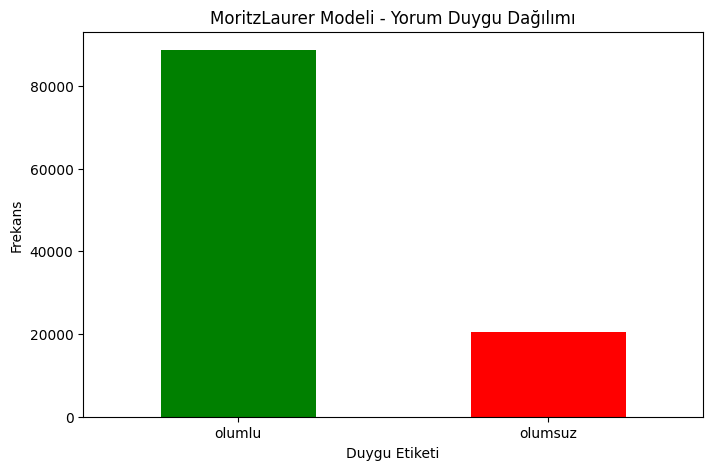

In [ ]:
label_counts = df_comments["MoritzLaurer_label"].value_counts()

plt.figure(figsize=(8, 5))
label_counts.plot(kind="bar", color=["green", "red"])  
plt.xlabel("Duygu Etiketi")
plt.ylabel("Frekans")
plt.title("MoritzLaurer Modeli - Yorum Duygu Dağılımı")
plt.xticks(rotation=0)  
plt.show()

In [ ]:
comment_path = os.path.join(os.path.expanduser("~"), "Desktop\\TrendyolMilla\\03_Data_Labelization\\Data\\Zero_Shot")
file_name = "comments_MoritzLaurer.csv"
file_path = os.path.join(comment_path, file_name)
df_comments.to_csv(file_path, index=False)  
print(f"{file_name} olarak kaydedildi.") 

comments_MoritzLaurer.csv olarak kaydedildi.


4 - Zero Shot Skorlarının Konsolidasyonu

In [ ]:
comments_path = os.path.join(os.path.expanduser("~"), "Desktop\\TrendyolMilla\\03_Data_Labelization\\Data\\Zero_Shot", "comments_MoritzLaurer.csv")

df_comments = pd.read_csv(comments_path)

df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor,MoritzLaurer_label,MoritzLaurer_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684,olumlu,0.930659,olumlu,0.984298
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,135,boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270,olumlu,0.857906,olumsuz,-0.775901
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. yaka kesimi hoş. biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739,olumlu,0.886708,olumlu,0.897199
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717,olumlu,0.956035,olumlu,0.985931
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,140,xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333,olumlu,0.595040,olumsuz,-0.520216


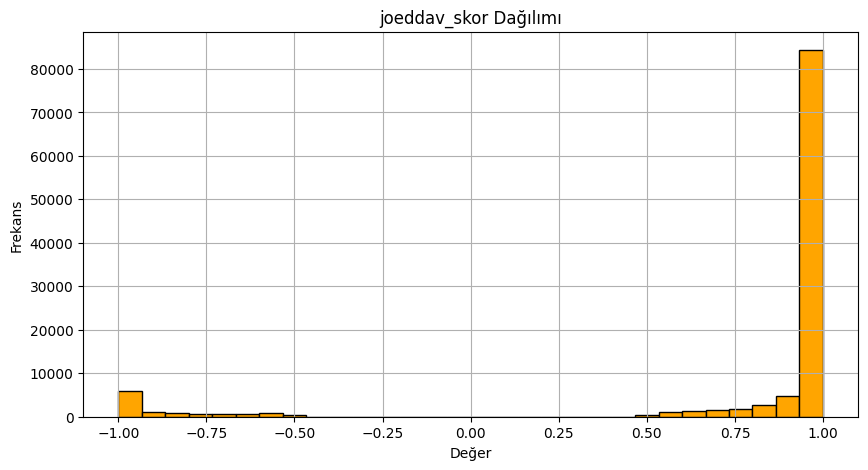

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(df_comments["joeddav_skor"], bins=30, color='orange', edgecolor='black')
plt.title("joeddav_skor Dağılımı")
plt.xlabel("Değer")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()

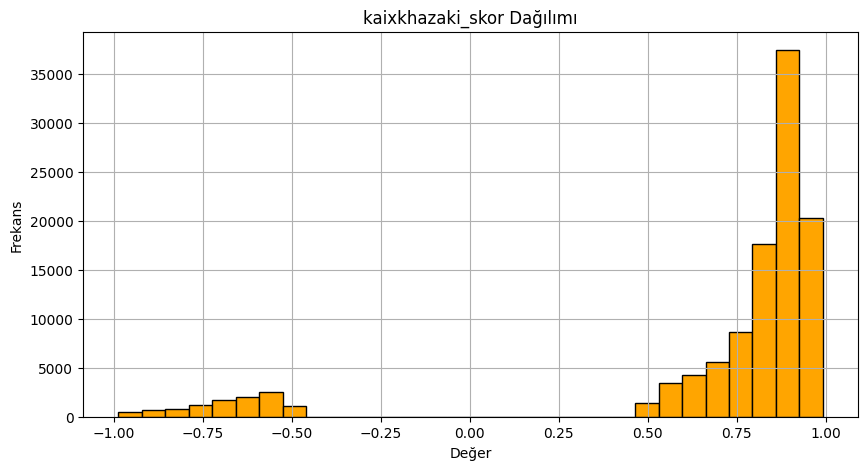

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(df_comments["kaixkhazaki_skor"], bins=30, color='orange', edgecolor='black')
plt.title("kaixkhazaki_skor Dağılımı")
plt.xlabel("Değer")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()

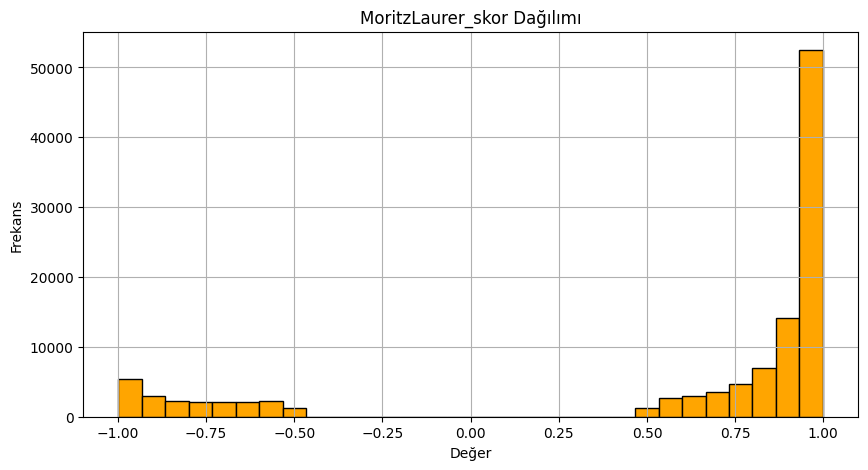

In [6]:
plt.figure(figsize=(10, 5))
plt.hist(df_comments["MoritzLaurer_skor"], bins=30, color='orange', edgecolor='black')
plt.title("MoritzLaurer_skor Dağılımı")
plt.xlabel("Değer")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()

In [7]:
df_comments["ZeroShot_skor"] = (df_comments["joeddav_skor"] + df_comments["kaixkhazaki_skor"] + df_comments["MoritzLaurer_skor"]) / 3
df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor,MoritzLaurer_label,MoritzLaurer_skor,ZeroShot_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684,olumlu,0.930659,olumlu,0.984298,0.970880
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,135,boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270,olumlu,0.857906,olumsuz,-0.775901,0.339425
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. yaka kesimi hoş. biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739,olumlu,0.886708,olumlu,0.897199,0.924882
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717,olumlu,0.956035,olumlu,0.985931,0.978561
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,140,xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333,olumlu,0.595040,olumsuz,-0.520216,-0.185503


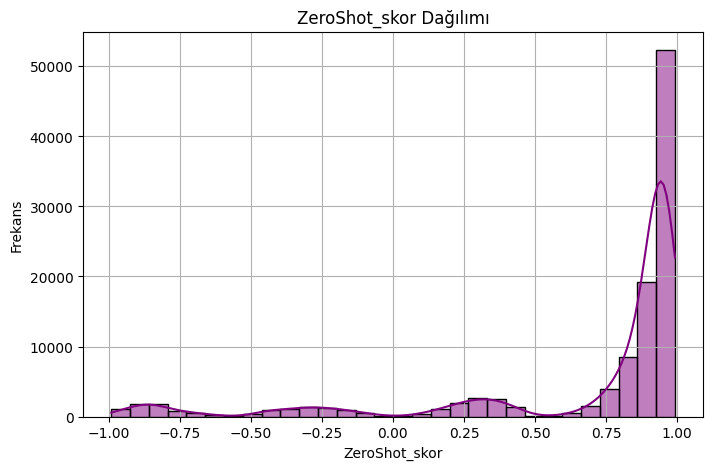

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df_comments["ZeroShot_skor"], bins=30, kde=True, color='purple')
plt.title("ZeroShot_skor Dağılımı")
plt.xlabel("ZeroShot_skor")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()

In [10]:
print((df_comments["ZeroShot_skor"] > 0).sum(), "pozitif değer")
print((df_comments["ZeroShot_skor"] < 0).sum(), "negatif değer")
print((df_comments["ZeroShot_skor"] == 0).sum(), "sıfır")

96270 pozitif değer
12872 negatif değer
0 sıfır


In [12]:
df_comments["ZeroShot_label"] = df_comments["ZeroShot_skor"].apply(lambda x: "olumlu" if x > 0 else "olumsuz")
df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor,MoritzLaurer_label,MoritzLaurer_skor,ZeroShot_skor,ZeroShot_label
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684,olumlu,0.930659,olumlu,0.984298,0.970880,olumlu
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,135,boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270,olumlu,0.857906,olumsuz,-0.775901,0.339425,olumlu
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. yaka kesimi hoş. biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739,olumlu,0.886708,olumlu,0.897199,0.924882,olumlu
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717,olumlu,0.956035,olumlu,0.985931,0.978561,olumlu
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,140,xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333,olumlu,0.595040,olumsuz,-0.520216,-0.185503,olumsuz


In [13]:
ZeroShot_label_values = df_comments["ZeroShot_label"] 
ZeroShot_skor_values  = df_comments["ZeroShot_skor"]    

df_comments = df_comments.drop(columns=["ZeroShot_label", "ZeroShot_skor"])

df_comments["ZeroShot_label"] = ZeroShot_label_values
df_comments["ZeroShot_skor"] = ZeroShot_skor_values

df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor,MoritzLaurer_label,MoritzLaurer_skor,ZeroShot_label,ZeroShot_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",Positive,0.931962,Positive,0.963947,Positive,0.947954,olumlu,0.997684,olumlu,0.930659,olumlu,0.984298,olumlu,0.970880
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,135,boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,Negative,-0.669085,Positive,0.991367,Positive,0.161141,olumlu,0.936270,olumlu,0.857906,olumsuz,-0.775901,olumlu,0.339425
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. yaka kesimi hoş. biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,Negative,-0.964131,Positive,0.924904,Negative,-0.019614,olumlu,0.990739,olumlu,0.886708,olumlu,0.897199,olumlu,0.924882
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",Positive,0.906424,Positive,0.974138,Positive,0.940281,olumlu,0.993717,olumlu,0.956035,olumlu,0.985931,olumlu,0.978561
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,140,xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,Negative,-0.999406,Positive,0.791039,Negative,-0.104184,olumsuz,-0.631333,olumlu,0.595040,olumsuz,-0.520216,olumsuz,-0.185503


5 - Zero Shot ve Bert Çıktıları Aynı Formata Getirilir

In [14]:
df_comments["savasy_label"] = df_comments["savasy_label"].apply(lambda x: "olumlu" if x == "Positive" else "olumsuz")
df_comments["bayrameker_label"] = df_comments["bayrameker_label"].apply(lambda x: "olumlu" if x == "Positive" else "olumsuz")
df_comments["bert_label"] = df_comments["bert_label"].apply(lambda x: "olumlu" if x == "Positive" else "olumsuz")

df_comments.head()

,Tarih,Boy,Kilo,Beden,Yorum,Ürün Adı,Yorum_V1,Yorum Uzunluğu,Yorum_V2,savasy_label,savasy_skor,bayrameker_label,bayrameker_skor,bert_label,bert_skor,joeddav_label,joeddav_skor,kaixkhazaki_label,kaixkhazaki_skor,MoritzLaurer_label,MoritzLaurer_skor,ZeroShot_label,ZeroShot_skor
0,17 Şubat 2025,168cm,55,S,"Çok güzel 1.68 ,55 kilo s beden tam oldu",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"Çok güzel 1.68 ,55 kilo s beden tam oldu",40,"çok güzel 1.68 ,55 kilo s beden tam oldu",olumlu,0.931962,olumlu,0.963947,olumlu,0.947954,olumlu,0.997684,olumlu,0.930659,olumlu,0.984298,olumlu,0.970880
1,14 Şubat 2025,165cm,59,S,Boyum 1.65 bi tik daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,135,boyum 1.65 bir tık daha uzun olsa elbise iyi olabilirmiş ense kısmı biraz açık boyun kısmına göre ama güzel elbise severek kullanıyorum,olumsuz,-0.669085,olumlu,0.991367,olumlu,0.161141,olumlu,0.936270,olumlu,0.857906,olumsuz,-0.775901,olumlu,0.339425
2,23 Aralık 2024,168cm,60,S,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,1.68 boy 60 kilo s beden cuk oturdu. Wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. Yaka kesimi hoş. Biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,203,1.68 boy 60 kilo s beden cuk oturdu. wow değil ama gayet günlük şık bir elbise botlarla da güzel duruyor. yaka kesimi hoş. biraz ince sadece kumaşı ama içine çorap body ile giyince soğuklarda da giyilir.,olumsuz,-0.964131,olumlu,0.924904,olumsuz,-0.019614,olumlu,0.990739,olumlu,0.886708,olumlu,0.897199,olumlu,0.924882
3,03 Şubat 2025,Bilgi mevcut değil,Bilgi mevcut değil,M,"çok beğendim, kumaşı farklı ve gerçekten çok şık",TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,"çok beğendim, kumaşı farklı ve gerçekten çok şık",48,"çok beğendim, kumaşı farklı ve gerçekten çok şık",olumlu,0.906424,olumlu,0.974138,olumlu,0.940281,olumlu,0.993717,olumlu,0.956035,olumlu,0.985931,olumlu,0.978561
4,01 Şubat 2025,157cm,46,S,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,TRENDYOLMİLLA Siyah Düz Dokulu Fitted/Vücuda Oturan Maxi Örme Elbise TWOAW25EL00097,Xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,140,xs uzun süredir gelmediği için s aldım 157*46 kg bol oldu terziye vererek kurtardım ama tavsiye etmem model bozuluyor kendi bedeninizi alın.,olumsuz,-0.999406,olumlu,0.791039,olumsuz,-0.104184,olumsuz,-0.631333,olumlu,0.595040,olumsuz,-0.520216,olumsuz,-0.185503


In [ ]:
comment_path = os.path.join(os.path.expanduser("~"), "Desktop\\TrendyolMilla\\03_Data_Labelization\\Data\\Zero_Shot")
file_name = "comments_zero_shot_consolidation.csv"
file_path = os.path.join(comment_path, file_name)
df_comments.to_csv(file_path, index=False)  
print(f"{file_name} olarak kaydedildi.") 

comments_zero_shot_consolidation.csv olarak kaydedildi.
